# Legacy code

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

# Render here
class FSMRenderingEnvWrapper(gym.Wrapper):
  """
  :param env: (gym.Env) Gym environment that will be wrapped
  """
  def __init__(self, env: gym.Env):

    # Initialize the graph here
    self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
    self.rendering_heatmap_dict = {}
    self.num_timesteps = 0
    self.total_amount_of_visits = 0
    
    # Add a node and edge during step function

    # Store the amount of visits to a node
    # When drawing, convert that to RGB:
    
    # Node A: 30 visits
    # Node B: 1 visit

    # Node A: 255, 255, 255
    # Node B: 1, 1, 1

    # Call the parent constructor, so we can access self.env later
    super(FSMRenderingWrapper, self).__init__(env)
  
  def reset(self):
    """
    Reset the environment 
    """
    obs = self.env.reset()

    # Add the initial node
    if self.env.current_unique_id_state not in self.rendering_heatmap_dict:
      self.rendering_heatmap_dict[self.env.current_unique_id_state] = 1

      with open(self.env.file_name, 'r') as csv_file:
        # pass the file object to DictReader() to get the DictReader object
        csv_dict_reader = DictReader(csv_file)

        # iterate over each line as a ordered dictionary
        for row in csv_dict_reader:
          # row variable is a dictionary that represents a row in csv
          if int(row['Unique_ID']) == self.env.current_unique_id_state:
            # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
            original_name = row['State_name']
            
      start_state_name = original_name + " " + "[START STATE]"

      self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))

    # else:
    #   self.rendering_heatmap_dict[self.env.current_unique_id_state] += 1
    #   self.total_amount_of_visits += 1
      
    return obs

  def step(self, action):
    """
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    # Store temporarily current unique id to draw edge
    previous_node = self.env.current_unique_id_state

    obs, reward, done, info = self.env.step(action)

    new_node_found = False

    # STORE AMOUNT OF VISITS AT ALL TIMES
    # Just create a new node if not in the heatmap dict yet and is not start state id
    # wait, no
    # actually yes - make it a black void

    # if self.env.current_unique_id_state != self.env.start_state_id:
    if self.env.current_unique_id_state not in self.rendering_heatmap_dict:
      self.rendering_heatmap_dict[self.env.current_unique_id_state] = 1
      new_node_found = True
    
    else:
      self.rendering_heatmap_dict[self.env.current_unique_id_state] += 1
      self.total_amount_of_visits += 1

    with open(self.env.file_name, 'r') as csv_file:
      # pass the file object to DictReader() to get the DictReader object
      csv_dict_reader = DictReader(csv_file)

      # iterate over each line as a ordered dictionary
      for row in csv_dict_reader:
        if int(row['Unique_ID']) == previous_node:
          transition_name = row['Transition_names'].split()[action]
          
        if new_node_found == True:
        # row variable is a dictionary that represents a row in csv
          if int(row['Unique_ID']) == self.env.current_unique_id_state:
            # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
            original_name = row['State_name']
    
    if new_node_found == True:
      if self.env.randomize_start_state == True:
        if self.env.current_unique_id_state in self.env.start_states:
          start_state_name = original_name + " " + "[START STATE]"
          self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
        else:
          self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
      else:
        self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
    
    current_node = self.env.current_unique_id_state 
    # Add edge between previous and current node
    self.rendering_graph.add_edge(pydot.Edge(previous_node, current_node, label=transition_name, color='black', fontname="Arial", fontsize='32'))
    
    self.num_timesteps += 1

    if self.num_timesteps % 5000 == 0:
      local_max = 0
      for node in self.rendering_graph.get_nodes():
        if self.rendering_heatmap_dict[int(node.get_name())] > local_max:
          local_max = self.rendering_heatmap_dict[int(node.get_name())]
          
      for node in self.rendering_graph.get_nodes():
        amount_of_visits = self.rendering_heatmap_dict[int(node.get_name())]
        # Convert the range from 0.0 - local_max to 1.0 - 0.0 for heatmap colouring
        # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
        # Linear something
        new_hsv_value = (-amount_of_visits / local_max) + 1.0
        node.set_fillcolor("0.0 0.0 {}".format(new_hsv_value))
        if new_hsv_value <= 0.5:
          node.set_fontcolor("white")

        # with open(self.env.file_name, 'r') as csv_file:
        #   # pass the file object to DictReader() to get the DictReader object
        #   csv_dict_reader = DictReader(csv_file)

        #   # iterate over each line as a ordered dictionary
        #   for row in csv_dict_reader:
        #     # row variable is a dictionary that represents a row in csv
        #     if row['Unique_ID'] == node.get_name():
        #       print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
        #       node.set_label(row['State_name'] + " " + str(self.rendering_heatmap_dict[int(node.get_name())]) + "/" + str(self.total_amount_of_visits))
              
        # node.set_label(self.rendering_heatmap_dict[int(node.get_name())])
            
      clear_output(wait=True)
      plt = Image(self.rendering_graph.create_png())
      display(plt)
      for k, v in self.rendering_heatmap_dict.items():
        with open(self.env.file_name, 'r') as csv_file:
          # pass the file object to DictReader() to get the DictReader object
          csv_dict_reader = DictReader(csv_file)

          # iterate over each line as a ordered dictionary
          for row in csv_dict_reader:
            if int(row['Unique_ID']) == k:
              # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
              original_name = row['State_name']
        print(original_name, v)

    return obs, reward, done, info


In [ ]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

# Instantiate the env
env = FSMEnv('pelican.csv', start_state_id=1, use_default_obs_space_limits=False)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)
# env = FSMRenderingWrapper(env)
# wrap it again

In [ ]:
# Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
# model = A2C('MultiInputPolicy', env, gamma=0.99, verbose=1).learn(100000)

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)

graph.add_node(pydot.Node(name=1, style="filled", fillcolor="0.0 0.0 0.5", fontcolor="black"))
graph.add_node(pydot.Node(name=2, style="filled", fillcolor="0.0 0.0 0.0"))
graph.add_edge(pydot.Edge(1, 3))
graph.add_edge(pydot.Edge(1, 4))
graph.add_edge(pydot.Edge(2, 4))

for node in graph.get_nodes():
    print(node.get_label())

for edge in graph.get_edges():
    print(type(edge.get_source()), type(edge.get_destination()))

plt = Image(graph.create_png())
display(plt)

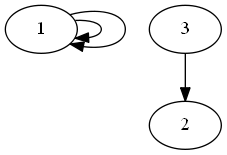

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=False)
graph.add_edge(pydot.Edge("1", "1"))
graph.add_edge(pydot.Edge("1", "1"))
graph.add_edge(pydot.Edge("3", "2"))
plt = Image(graph.create_png())
display(plt)

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)
for i in range(2, 100):
    graph.add_edge(pydot.Edge("1", "{}".format(i)))
    graph.add_edge(pydot.Edge("{}".format(i-1), "{}".format(i)))
    if i % 50 == 0:
        print("Aaa")
        # plt = Image(graph.create_png())
        # display(plt)
        # clear_output(wait=True)
graph.write_png("Aaa.png")

In [ ]:
a = [1, 2]
b = [3, 4]
c = [5, 6]

for x, y, z in zip(a, b, c):
    print(x, y, z)

In [ ]:
f = open("ck.txt", "w+")
for i in range(10000):
    f.write("5,S4,0,2,0 1,6 4,5\n")

In [ ]:
f.close()

In [ ]:
import numpy as np

print(np.iinfo(np.int32).max)
print(np.iinfo(np.int64).max)

In [ ]:
test = np.array([1,2,3,4])

new = test[1:]
np.append(new, 2)